# Решающее дерево для задачи регрессии


Ваше домашнее задание состоит из 2 частей, задания 1-3 включают в себя имплементацию алгоритма Решающего дерева для задачи регрессии, в задании 4 необходимо применить метод решающего дерева к набору данных стоимости квартир.

# 1. Починить имплементацию решающего дерева

Ниже представлена наивная имплементация алгоритма Решающего дерева для задачи регрессии и пример запуска. В качестве критерия остановки выступает максимальная глубина дерева и минимальное количество наблюдений в листе.

Вам необходимо внести несколько изменений:

    1.1  Сейчас параметр `min_samples_leaf` не используется, таким образом в листах дерева может оказаться произвольное количество наблюдений, вам необходимо это починить.
    1.2 Для удобства отслеживания числа наблюдений в каждом узле добавьте поле "support" (количество наблюдейний в текущем узле) в словарь `self.tree`.

In [1]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth, min_samples_leaf):
        """
        max_depth, int - максимальная глубина дерева
        min_samples_leaf, int - минимальное количество наблюдений в листе
        """
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
        
    def _split_data(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        return X_left, y_left, X_right, y_right
    
    def _mse(self, y):
        return np.mean((y - np.mean(y))**2)
    
    def _best_split(self, X, y):
        best_feature_index, best_threshold = None, None
        best_mse = float('inf')
        n_features = X.shape[1]
        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
                mse_left = self._mse(y_left)
                mse_right = self._mse(y_right)
                mse_split = (len(y_left) * mse_left + len(y_right) * mse_right) / len(y)
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feature_index = feature_index
                    best_threshold = threshold
        return best_feature_index, best_threshold
    
    def _build_tree(self, X, y, depth):
        if depth == self.max_depth:
            return np.mean(y)
        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            return np.mean(y)
        X_left, y_left, X_right, y_right = self._split_data(X, y, feature_index, threshold)
        tree = {
            'feature_index': feature_index,
            'threshold': threshold
        }
        tree['left'] = self._build_tree(X_left, y_left, depth + 1)
        tree['right'] = self._build_tree(X_right, y_right, depth + 1)
        return tree
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def _predict_one(self, tree, x):
        if isinstance(tree, float):
            return tree
        feature_index, threshold = tree['feature_index'], tree['threshold']
        if x[feature_index] <= threshold:
            return self._predict_one(tree['left'], x)
        else:
            return self._predict_one(tree['right'], x)
        
    def predict(self, X):
        predictions = []
        for x in X:
            prediction = self._predict_one(self.tree, x)
            predictions.append(prediction)
        return np.array(predictions)

In [2]:
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=50)

In [3]:
from sklearn.datasets import fetch_openml

In [22]:
X, y = fetch_openml(name="house_prices", as_frame=True, return_X_y=True)
X = X.dropna(axis=1)
X = X.loc[:, X.dtypes == 'int64']
X.drop('Id', axis=1, inplace=True)

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [23]:
X

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,706,0,150,856,...,548,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,978,0,284,1262,...,460,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,486,0,434,920,...,608,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,216,0,540,756,...,642,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,655,0,490,1145,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,7917,6,5,1999,2000,0,0,953,953,...,460,0,40,0,0,0,0,0,8,2007
1456,20,13175,6,6,1978,1988,790,163,589,1542,...,500,349,0,0,0,0,0,0,2,2010
1457,70,9042,7,9,1941,2006,275,0,877,1152,...,252,0,60,0,0,0,0,2500,5,2010
1458,20,9717,5,6,1950,1996,49,1029,0,1078,...,240,366,0,112,0,0,0,0,4,2010


In [24]:
dt.fit(X.values, y.values)

/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/homes/anvar/anaconda3/envs/cuda311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
dt.predict(X.values[:5])

array([194238.74476987, 124907.77836879, 194238.74476987, 194238.74476987,
       314894.55384615])

In [26]:
dt.tree

{'feature_index': 2,
 'threshold': 7,
 'left': {'feature_index': 2,
  'threshold': 6,
  'left': {'feature_index': 13,
   'threshold': 1376,
   'left': 124907.77836879433,
   'right': 165466.08908045976},
  'right': {'feature_index': 13,
   'threshold': 1935,
   'left': 194238.74476987447,
   'right': 247980.9875}},
 'right': {'feature_index': 2,
  'threshold': 8,
  'left': {'feature_index': 13,
   'threshold': 1970,
   'left': 249392.46601941748,
   'right': 314894.55384615384},
  'right': {'feature_index': 11,
   'threshold': 1538,
   'left': 371942.2586206897,
   'right': 708333.3333333334}}}

# 2. Воспользуйтесь `line_profiler` 

Текущая имплементация Решающего дерева работает очень медленно. Чтобы локализовать что отнимает так много времени воспользуйтесь `line_profiler`.

    2.1 Что занимает больше всего времени на этапе обучения решающего дерева?
    
https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [ ]:
pip install line_profiler

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f dt._build_tree dt._build_tree(X.values[:100], y.values[:100], 7)

# 3. Гистограммы

Вместо того чтобы перебирать все уникальные значения признака в методе `self._best_split` мы будем восстанавливать гистограмму распределения признака и перебирать только уникальные значения в бинах, см. пример:

In [27]:
x = np.random.normal(0, 1, 200)

In [28]:
len(np.unique(x))

200

In [29]:
bins_height, bins_edges = np.histogram(x, bins=10)
bins_centers = (bins_edges[:-1]+bins_edges[1:])/2

In [30]:
len(bins_centers)

10

Т.е. вместо "200" уникальных трешхолдов мы будем использовать только "10".

In [31]:
import matplotlib.pyplot as plt

In [32]:
bins_centers

array([-2.29733801, -1.7688628 , -1.24038759, -0.71191237, -0.18343716,
        0.34503806,  0.87351327,  1.40198848,  1.9304637 ,  2.45893891])

In [33]:
# Ширина бинов одинакова
bins_edges[:-1]-bins_edges[1:] 

array([-0.52847521, -0.52847521, -0.52847521, -0.52847521, -0.52847521,
       -0.52847521, -0.52847521, -0.52847521, -0.52847521, -0.52847521])

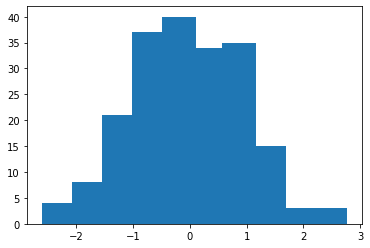

In [34]:
plt.bar(bins_centers, bins_height, width=0.6);

### Выбор числа бинов

Количество бинов гистограммы может сильно повлиять на то как вы приближаете ваше распределение

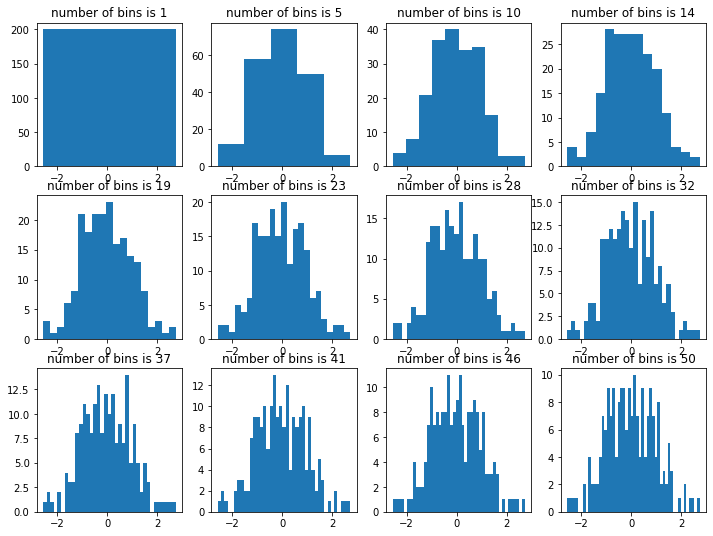

In [35]:
fig, axs = plt.subplots(3, 4, figsize=(12, 9))
n_bins = np.round(np.linspace(1, 50, 12)).astype(int)

for i, ax in enumerate(axs.flatten()):
    ax.hist(x, bins=n_bins[i])
    ax.set_title(f'number of bins is {n_bins[i]}')

### Метод Freedman–Diaconis 

https://en.wikipedia.org/wiki/Freedman%E2%80%93Diaconis_rule

Для выбора числа бинов в гистограмме воспользуйте правилом Freedman–Diaconis:

$$\text{Bin width} = 2 \cdot \frac{IQR(x)}{x^{1/3}}$$

Где IQR это inter quartile range, то есть расстояние между 25 и 75 перцентилем распределения.

    3.1 Метод Freedman–Diaconis дает формулу для ширины бина (одинаковая для всех бинов), а чему в таком случае равно число бинов?
    3.2 Имплементируйте функцию для подсчета числа бинов по формуле Freedman–Diaconis

In [36]:
# iqr
np.quantile(x, 0.75) - np.quantile(x, 0.25)

1.4244462734695484

### В методе `self._best_split` замените перебор всех уникальных трешхолдов на перебор только по уникальным бинам

Количество бинов подбирайте методом Freedman–Diaconis

    3.3 Засеките время обучения вашего регрессора до и после имплементации гистограмм, насколько быстрее стало обучение?
    3.4 Сравните скорость работы вашей имплементации решающего дерева и имплементации sklearn.tree.DecisionTreeRegressor, с аналогичными гиперпараметрами
    3.5 Опишите другие способы ускорения алгоритма решающего дерева (кроме приближения распределений признаков гистограмми)

# 4. House pricing

воспользуйтесь набором данных из ДЗ2. Обучите алгоритм Решающего дерева (воспользуйтесь имплементацией из sklearn), не забудьте разделить данные на тренировочную и тестовую выборки. 

    4.1. Влияет ли нормировка признаков на алгоритм Решающего дерева? Почему?
    4.2. Переберите различные значения гиперпараметров решающего дерева с использованием функции GridSearchCV, какое наилучшее качество в терминах mean_squared_error вам удалось получить? Насколько это лучше/хуже качества линейных моделей (на том же train-test разбиении).
    4.3. Сравните важность признаков которую предлагает встроенный метод DecisionTreeRegressor().feature_importances_ с важностью признаков полученной для линейных моделей, прокомментируйте.

jupyter notebook c вашим решением необходимо отправить на почту kurmukovai@gmail.com, с темой письма [iitp-intro-ds-2024-ha4-Surname], например [iitp-intro-ds-2024-ha4-Kurmukov] до 12:59:59 МСК 29.02.2024. Дополнительный балл за раннюю сдачу до 23:59:59 27.02.2024